In [2]:
#importing modules
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sklearn.metrics

In [3]:
#ODE SOLVER
G = 1.0  # gravitational constant

def two_body_ode(t, y, m1, m2):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y

    #compute distance
    dx = x2 - x1
    dy = y2 - y1
    dist_sq = dx**2 + dy**2
    dist = np.sqrt(dist_sq)
    factor = G / (dist_sq * dist + 1e-8)  # avoid division by zero

    ax1 =  m2 * dx * factor
    ay1 =  m2 * dy * factor
    ax2 = -m1 * dx * factor
    ay2 = -m1 * dy * factor

    return [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]


In [4]:
#Training dataset
# Parameters
num_samples = 500   # Number of training trajectories
t_span = (0, 20)    # Simulate from t=0 to t=20
t_eval = np.linspace(*t_span, 200)  # 200 time steps

# Storage
X_train = []
Y_train = []

for _ in range(num_samples):
    # Random initial conditions
    m1 = np.random.uniform(1, 5)
    m2 = np.random.uniform(1, 5)

    x1 = np.random.uniform(-5, 5, size=2)
    x2 = np.random.uniform(-5, 5, size=2)
    v1 = np.random.uniform(-2, 2, size=2)
    v2 = np.random.uniform(-2, 2, size=2)

    # Initial state vector
    y0 = [x1[0], x1[1], x2[0], x2[1], v1[0], v1[1], v2[0], v2[1]]

    # Solve ODE
    sol = solve_ivp(
        fun=lambda t, y: two_body_ode(t, y, m1, m2),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        rtol=1e-9,
        atol=1e-9
    )

    # Store time and corresponding positions
    for i, t in enumerate(sol.t):
        X_train.append([t, m1, m2, *x1, *x2, *v1, *v2])  # Input: time and initial conditions
        Y_train.append([sol.y[0, i], sol.y[1, i], sol.y[2, i], sol.y[3, i]])  # Output: x1, y1, x2, y2

# Convert to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [5]:
# Convert NumPy arrays to float32 PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32)


In [6]:
train_dataset = TensorDataset(X_tensor, Y_tensor)

# Use batching to speed up and stabilize training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [7]:
#Testing dataset
# Parameters
num_samples_t = 400   # Number of testing trajectories
t_span_t = (0, 10)    # Simulate from t=0 to t=10
t_eval_t = np.linspace(*t_span_t, 100)  # 100 time steps

# Storage
X_test = []
Y_test = []

for _ in range(num_samples_t):
    # Random initial conditions
    m1 = np.random.uniform(5, 10)
    m2 = np.random.uniform(5, 10)

    x1 = np.random.uniform(5, 12, size=2)
    x2 = np.random.uniform(5, 12, size=2)
    v1 = np.random.uniform(-4, 4, size=2)
    v2 = np.random.uniform(-4, 4, size=2)

    # Initial state vector
    y0 = [x1[0], x1[1], x2[0], x2[1], v1[0], v1[1], v2[0], v2[1]]

    # Solve ODE
    sol = solve_ivp(
        fun=lambda t, y: two_body_ode(t, y, m1, m2),
        t_span=t_span_t,
        y0=y0,
        t_eval=t_eval_t,
        rtol=1e-9,
        atol=1e-9
    )

    # Store time and corresponding positions
    for i, t in enumerate(sol.t):
        X_test.append([t, m1, m2, *x1, *x2, *v1, *v2])  # Input: time and initial conditions
        Y_test.append([sol.y[0, i], sol.y[1, i], sol.y[2, i], sol.y[3, i]])  # Output: x1, y1, x2, y2

# Convert to NumPy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)


In [8]:
# Convert NumPy arrays to float32 PyTorch tensors
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
Y_tensor_test = torch.tensor(Y_test, dtype=torch.float32)


In [9]:
test_dataset = TensorDataset(X_tensor_test, Y_tensor_test)

# Use batching to speed up and stabilize training
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [10]:
#Model Definition
class TwoBodyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),  # Input layer
            nn.Tanh(),
            nn.Linear(128, 128),               # Hidden layer
            nn.Tanh(),
            nn.Linear(128, 4)                  # Output: x1, y1, x2, y2
        )

    def forward(self, x):
        return self.net(x)

model = TwoBodyNet()


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
#Training model
epochs = 500

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


Epoch 1, Loss: 58525.96
Epoch 2, Loss: 15390.57
Epoch 3, Loss: 5953.23
Epoch 4, Loss: 2719.27
Epoch 5, Loss: 1462.17
Epoch 6, Loss: 927.28
Epoch 7, Loss: 669.72
Epoch 8, Loss: 524.71
Epoch 9, Loss: 448.07
Epoch 10, Loss: 389.69
Epoch 11, Loss: 345.77
Epoch 12, Loss: 323.83
Epoch 13, Loss: 294.76
Epoch 14, Loss: 286.30
Epoch 15, Loss: 264.73
Epoch 16, Loss: 259.73
Epoch 17, Loss: 246.87
Epoch 18, Loss: 238.26
Epoch 19, Loss: 229.95
Epoch 20, Loss: 219.59
Epoch 21, Loss: 219.06
Epoch 22, Loss: 209.38
Epoch 23, Loss: 209.92
Epoch 24, Loss: 200.87
Epoch 25, Loss: 201.47
Epoch 26, Loss: 189.42
Epoch 27, Loss: 192.11
Epoch 28, Loss: 183.85
Epoch 29, Loss: 187.69
Epoch 30, Loss: 177.72
Epoch 31, Loss: 176.82
Epoch 32, Loss: 178.41
Epoch 33, Loss: 168.04
Epoch 34, Loss: 174.22
Epoch 35, Loss: 170.58
Epoch 36, Loss: 167.31
Epoch 37, Loss: 166.81
Epoch 38, Loss: 163.15
Epoch 39, Loss: 161.05
Epoch 40, Loss: 161.04
Epoch 41, Loss: 160.53
Epoch 42, Loss: 153.15
Epoch 43, Loss: 156.41
Epoch 44, Los

In [14]:
with torch.no_grad():
    Y_pred = model(X_tensor_test)


In [21]:
#Evalution criteria
mae = nn.L1Loss()   # Mean Absolute Error
mse = nn.MSELoss()  # Mean Squared Error

mae_error = mae(Y_pred, Y_tensor_test)
mse_error = mse(Y_pred, Y_tensor_test)

print(f"MAE on test data: {mae_error.item():.6f}")
print(f"MSE on test data: {mse_error.item():.6f}")


MAE on test data: 6.926276
MSE on test data: 83.321045


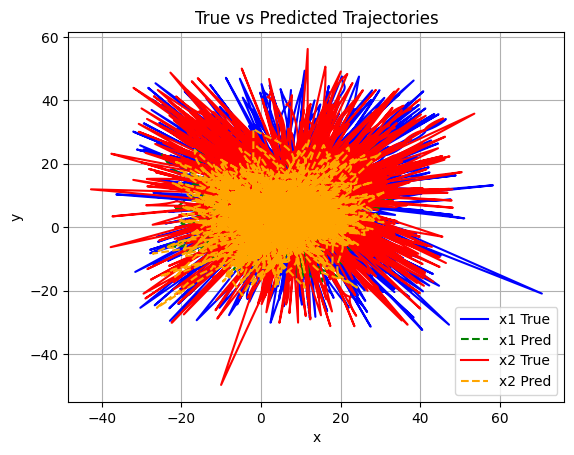

In [22]:
#Visualization

# Separate coordinates
x1_true = Y_test[:, 0]
y1_true = Y_test[:, 1]
x2_true = Y_test[:, 2]
y2_true = Y_test[:, 3]

x1_pred = Y_pred[ :, 0].numpy()
y1_pred = Y_pred[: , 1].numpy()
x2_pred = Y_pred[: , 2].numpy()
y2_pred = Y_pred[ :, 3].numpy()

plt.plot(x1_true, y1_true, label='x1 True', color='blue')
plt.plot(x1_pred, y1_pred, '--', label='x1 Pred', color='green')

plt.plot(x2_true, y2_true, label='x2 True', color='red')
plt.plot(x2_pred, y2_pred, '--', label='x2 Pred', color='orange')

plt.legend()
plt.title('True vs Predicted Trajectories')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
